# Quantum Kicked Top

Study of the Quantum Kicked top based on Haake's 1987 paper. The main difference is that we do not use a Loschmidt and therefore we don't need another perturbation. Just the perturbation term in the Hamiltonian. Our hamiltonian is 
$$H(t) = \frac{\hbar p}{\tau} J_y + \frac{\hbar k}{2 j} J_z^2 \sum_{n=-\infty}^{\infty} \delta (t - n \tau)$$
The corresponding Floquet operator is
$$U = e^{-i k J^2_z/2 j } e^{-i p J_y}$$
There are mainly two possible ways, we can diagonalize numerically the Floquet operator, find its eigenstates and from there compute the relevant quantities. A more analytical approach would follow equations (5.5)... on Haake's paper. 
The code here mostly follows the previous QKT_Sim code

First of all we define the Basis in which we will be working
$$\mathfrak{B} = \{|S, -S\rangle, |S, -S+ 1 \rangle , ... , |S, S \rangle\}$$
Our first task is to compute the $S_x$ and $S_y$ operators in this basis, which can be obtained simply with the ladder operators as
$$S_x = \frac{S_+ - S_y}{2} \qquad S_y = - \frac{i(S_+ - S_-)}{2}$$
and the action of these operators on a ket of the basis is just
$$S_+ |S, m \rangle = \hbar \sqrt{S(S+1) - m (m+1)}|S, m+1 \rangle \quad S_- |S, m \rangle = \hbar \sqrt{S(S+1) - m (m-1)}|S, m-1 \rangle $$

In [1]:
import numpy as np
import numba
from numba.types import *
from numba import prange
import matplotlib.pyplot as plt
from numpy.linalg import eig, multi_dot, inv
from numpy import sin
from numpy import pi
from scipy.optimize import curve_fit
from scipy.linalg import schur
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size']=20
from scipy.linalg import expm
from numpy.linalg import matrix_power
from scipy.stats import linregress

In [2]:
S=100
dim=int(2*S+1)
τ=1
k=5
p=np.pi/2
i=complex(0, 1)
basis = np.identity(dim)
N_av=100
h_eff=1/(S)

In [3]:
#Definition of the ladder operators
@numba.jit(numba.types.Tuple((float64, float64[:]))(float64[:], float64), nopython=True, fastmath=True, parallel=False)
def S_p(ket, S):
    site= np.argmax(ket)
    m=site-S
    ket_out=np.zeros(dim)
    if site== 2*S:
        coef=0
        return (coef, ket_out)
    else:
        coef=np.sqrt(S*(S+1)-m*(m+1))
        ket_out[site+1]= 1
        return (coef, ket_out)
@numba.jit(numba.types.Tuple((float64, float64[:]))(float64[:], float64), nopython=True, fastmath=True, parallel=False)
def S_m(ket, S):
    site= np.argmax(ket)
    m=site-S
    ket_out=np.zeros(dim)
    if site== 0:
        coef=0
        return (coef, ket_out)
    else:
        coef= np.sqrt(S*(S+1)-m*(m-1))
        ket_out[site-1]= 1
        return (coef, ket_out)

In [4]:
@numba.jit(float64(float64[:], float64[:]), nopython=True, fastmath=True, parallel=False)
def braket(bra, ket):
    if np.all(bra== ket):
        return 1
    else:
        return 0

In [5]:
LOOKUP_TABLE = np.array([
    1, 1, 2, 6, 24, 120, 720, 5040, 40320,
    362880, 3628800, 39916800, 479001600,
    6227020800, 87178291200, 1307674368000,
    20922789888000, 355687428096000, 6402373705728000,
    121645100408832000, 2432902008176640000], dtype='int64')

@numba.jit(float64(int64), nopython=True, fastmath=True, parallel=False)
def fast_log_factorial(n):
    if n<20:
        return np.log(LOOKUP_TABLE[n])
    else:
        #stirling approx
        return n*np.log(n)-n+ 0.5*np.log(2*np.pi*n)
        #return n*np.log(n)-n+ 0.5*np.log(2*np.pi*n)+ 1/(12*n)-1/(360*n**3)

In [6]:
@numba.jit(float64[:,:](float64[:, :], float64), nopython=True, fastmath=True, parallel=False)
def Compute_Sx(basis, S):
    dim=int(2*S+1)
    Sx=np.zeros((dim, dim))
    for j in range(dim):
        for k in range(dim):
            ket=basis[j, :]
            bra=basis[k, :]
            coef_p, S_p_ket=S_p(ket, S)
            coef_m, S_m_ket=S_m(ket, S)
            result_p=braket(bra, S_p_ket)
            result_m=braket(bra, S_m_ket)
            Sx[j, k]=(coef_p*result_p+ coef_m*result_m)/2
    return Sx

@numba.jit(complex128[:,:](float64[:, :], float64), nopython=True, fastmath=True, parallel=False)
def Compute_Sy(basis, S):
    dim=int(2*S+1)
    Sy=np.zeros((dim, dim), dtype=complex128)
    i=complex(0,1)
    for j in range(dim):
        for k in range(dim):
            ket=basis[j, :]
            bra=basis[k, :]
            coef_p, S_p_ket=S_p(ket, S)
            coef_m, S_m_ket=S_m(ket, S)
            result_p=braket(bra, S_p_ket)
            result_m=braket(bra, S_m_ket)
            Sy[j, k]=-i*(coef_p*result_p- coef_m*result_m)/2
    return Sy

@numba.jit(float64[:,:](float64), nopython=True, fastmath=True, parallel=False)
def Compute_Sz(S):
    dim=int(2*S+1)
    Sz=np.zeros((dim, dim))
    for j in range(dim):
        m=j-S
        Sz[dim-1-j, dim-1-j]=m
    return Sz

$\textbf{Initial states}$

Since our problem is a spin problem and for chaos we need a wavepacket distributed over all of the eigenstates we initialize our state in coherent states of the SU(2) group, given by eq (4.3.15) of Perelomov's book as
$$|\zeta \rangle = \sum_{m =- S}^S \sqrt{\frac{(2S)!}{(S + m)! (S- m)!}}(1 + |\zeta|^2)^{-S} \zeta^{S + m} |S, m \rangle $$
We can relate $\zeta$ with the polar angles by 
$$\zeta= e^{i \varphi} \tan \frac{\theta}{2}$$

In [7]:
#Take into account that z is complex
@numba.jit(complex128[:](float64, complex128), nopython=True, fastmath=True, parallel=False)
def define_zeta(S, z):
    dim=int(2*S+1)
    ket_z=np.zeros(dim, dtype=complex128)
    for k in range(dim):
        m=k-S
        aux1=fast_log_factorial(int(2*S)) #aux1= log((2S)!)
        aux2=fast_log_factorial(int(S+m)) #aux2= log((S+m)!)
        aux3=fast_log_factorial(int(S-m)) #aux3= log((S-m)!)
        #ket_z[j]=np.sqrt(aux1/(aux2*aux3))*z**(S+m)/(1 + (np.abs(z))**2)**S
        #To deal with big numbers we introduce the log 
        #of the factorial, compute the division of them and afterwards we exponentiate
        ket_z[k]=np.exp((aux1-aux2-aux3)/2)*z**(S+m)/((1 + (np.abs(z))**2)**S) 
    norm= np.sqrt(np.conjugate(ket_z)@ket_z)
    return ket_z/norm
def linear(x, m,n):
    return m*x+n

$\textbf{Floquet operator}$

Now we compute the Floquet operator, given by
$$U = e^{-i k J^2_z/2 j } e^{-i p J_y}$$
Its diagonalization is
$$U = \xi \tilde{\lambda} \xi^\dagger$$
where $\xi$ is the eigenvectors matrix and $\tilde{\lambda}$ are the eignvalues $e^{i \phi}$ in a diagonal matrix. The n-th evolution then is
$$U^n = \xi \tilde{\lambda}^n \xi^\dagger= \xi e^{i n \phi} \xi^\dagger$$

In [8]:
Sx=np.zeros((dim, dim))
Sy=np.zeros((dim, dim), dtype=complex)
Sx=Compute_Sx(basis, S)
Sy=Compute_Sy(basis, S) #I've checked that for S=1/2, 1, 3/2 the results are the expected ones
Sz=Compute_Sz(S)

In [9]:
tx=0
ax=0
ty=0
ay=1
#tz=10
az=0
n_points_k=50
n_min=0
n_max=30
step_n=1
n_array=np.arange(n_min, n_max, step_n)
k_min=1
k_max=20
k_aux=np.linspace(np.log10(k_min), np.log10(k_max), n_points_k)
k_arr=10**k_aux
pseudoE=np.zeros((n_points_k, dim))
s_list=np.zeros(n_points_k*(dim-1))
#Z_beta=np.zeros(n_points_beta)
#DeltaE_beta=np.zeros(n_points_beta)
ind=0
lyapvsk=np.zeros(n_points_k)
sigma_lyap=np.zeros(n_points_k)
W=Sx
F_OTOC=np.zeros(len(n_array), dtype=complex)
for j in range(n_points_k):
    #U=expm(i*k_arr[j]*Sz@Sz/(2*S))@expm(-i*p*Sy)@expm(-i*k_arr[j]*Sz@Sz/(2*S))@expm(-i*p*Sy)
    U=expm(-i*k_arr[j]*Sz@Sz/(2*S))@expm(-i*p*Sy)
    #U=expm(i*p*Sz-i*k_arr[j]*Sz@Sz/(2*S))@expm(-i*p*Sy)
    #U=expm(-i*k_arr[j]*Sz@Sz/dim-i*az*Sz)@expm(-i*ty*Sy@Sy/dim-i*ay*Sy)@expm(-i*tx*Sx@Sx/dim-i*ax*Sx)
    U_n=matrix_power(U, n_array[0])
    invU_n=inv(U_n)
    for j_loop in range(len(n_array)):
        W_t=invU_n@W@U_n
        commX=Sx@W_t-W_t@Sx
        commY=Sy@W_t-W_t@Sy
        commZ=Sz@W_t-W_t@Sz
        F_OTOC[j_loop]= -1/(2*S+1)*(np.trace(commX@commX)+np.trace(commY@commY)+np.trace(commZ@commZ))
        U_n=U_n@matrix_power(U, step_n)
        invU_n=invU_n@matrix_power(inv(U), step_n)
    logF=np.log(F_OTOC)-np.log(F_OTOC[0])
    cutoff=0.7*np.max(logF)
    F_fit=np.abs(logF[logF<cutoff])
    t_fit=n_array[logF<cutoff]
    res=linregress(t_fit, F_fit)
    lyapvsk[j]=res.slope
    sigma_lyap[j]=res.stderr

In [10]:
clLyap=np.loadtxt("ClassicalLyap.txt") 

/home/pablo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


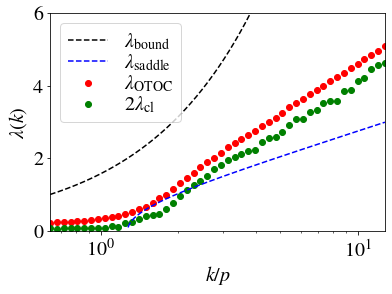

In [14]:
#print(lyapvsk)
k_c=np.linspace(k_min, k_max, 1000)
fig=plt.figure()
plt.scatter(k_arr/p, lyapvsk, color='red', label=r"$\lambda_\mathrm{OTOC}$")
plt.errorbar(k_arr/p, lyapvsk, yerr=sigma_lyap, linestyle='None', capsize=2, color='red')
plt.scatter(k_arr/p, 2*clLyap, color='green', label=r"$2 \lambda_\mathrm{cl}$")
plt.plot(k_c/p, k_c, color='black', ls='--', label=r"$\lambda_\mathrm{bound}$")
plt.plot(k_c/p, np.log(0.5*k_c+np.sqrt(0.25*k_c**2-1)), color='blue', ls='--', label=r"$\lambda_\mathrm{saddle}$")
#plt.plot(k_c, np.log(k_c*np.abs(np.sin(p)))-1)
#plt.xticks(ticks=np.asarray([1, 2, 5, 10]))
plt.xscale('log')
plt.xlim(k_min/p, k_max/p)
plt.ylim(0,6)
plt.ylabel(r"$\lambda(k)$")
plt.xlabel(r"$k/p$")
#plt.vlines(4, 0, 6, alpha=0.4, label=r"$\tau_z=\tau_x$")
#plt.xlim(1e-2, 20)
plt.legend(labelspacing=0)
plt.show()
